In [1]:
import pandas as pd
import numpy as np
import sqlite3
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

How many records does each dataset have in the sqlite db? 

In [2]:
query = """
SELECT COUNT(*) AS hopteaming_count
FROM hopteaming
"""

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    hopteaming_count = pd.read_sql(query, db)

hopteaming_count.head(3)

,hopteaming_count
0,34184634


In [3]:
query = """
SELECT COUNT(*) AS taxonomy_count
FROM taxonomy
"""

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    taxonomy_count = pd.read_sql(query, db)

taxonomy_count.head(3)

,taxonomy_count
0,874


In [4]:
query = """
SELECT COUNT(*) AS npi_count
FROM npi
"""

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    npi_count = pd.read_sql(query, db)

npi_count.head(3)

,npi_count
0,8180697


In [5]:
query = """
SELECT COUNT(*) AS zip_count
FROM zip_cbsa
"""

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    zip_count = pd.read_sql(query, db)

zip_count.head(3)

,zip_count
0,47598


In [6]:
query = """
SELECT * 
FROM zip_cbsa
WHERE cbsa = 34980
"""
start_time = time.time()

with sqlite3.connect('../data/data2/hop_teaming.sqlite') as db:
    nashville_cbsa = pd.read_sql(query, db)
    
end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")

nashville_cbsa.head(3)

Execution time: 0.036902666091918945 seconds


,zip,cbsa,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,37010,34980,ADAMS,TN,0.358611,0.909091,1.0,0.370867
1,37011,34980,ANTIOCH,TN,1.000000,1.000000,1.0,1.000000
2,37012,34980,ALEXANDRIA,TN,0.219592,0.043478,0.0,0.211719


After creating the sqlite database for the four datasets (hopteaming, taxonomy, zip_cbsa, and npi), merge datasets. 
- Next, download the **taxonomy** code to classification crosswalk from the National Uniform Claim Committee (https://www.nucc.org/index.php/code-sets-mainmenu-41/provider-taxonomy-mainmenu-40/csv-mainmenu-57). Using the primary taxonomy code, match each provider to a classification (from the Classification column).
- Finally, you need the **Zip code** to CBSA crosswalk from here: https://www.huduser.gov/portal/datasets/usps_crosswalk.html. Match each provider to a CBSA using the Business Zip code. Note that the zipcodes in the nppes dataset are either 5 or 9 digits, and be mindful that leading zeros might be dropped when reading the dataset into a dataframe. This can be used if you want to filter to providers just in the Nashville CBSA.

In [7]:
query = """
SELECT *
FROM npi 
LEFT JOIN taxonomy
ON npi.healthcare_provider_taxonomy_code = taxonomy.code
INNER JOIN zip_cbsa
ON npi.zip = zip_cbsa.zip
WHERE cbsa = 34980;
"""
start_time = time.time()

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    npi_nash  = pd.read_sql(query, db)
    
end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")
    
npi_nash.head(3)

Execution time: 14.13221526145935 seconds


,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,display_name,section,zip,cbsa,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,1013983808,1.0,None,SMITH,BEVERLY,KAY,MRS.,None,NP,836 DIXIE BEE RD,...,Family Nurse Practitioner,Individual,37010,34980,ADAMS,TN,0.358611,0.909091,1.0,0.370867
1,1346216199,1.0,None,GERTONSON,STEVEN,FREDRICK,MR.,None,CRNA,1950 BRADBURY RD,...,Certified Registered Nurse Anesthetist,Individual,37010,34980,ADAMS,TN,0.358611,0.909091,1.0,0.370867
2,1649660085,1.0,None,SMITH,KALEENA,DANIELLE,None,None,"M.S., CCC-SLP",948 NECTAR CT,...,Speech-Language Pathologist,Individual,37010,34980,ADAMS,TN,0.358611,0.909091,1.0,0.370867


In [8]:
len(npi_nash)

50824

**Tasks:**

- **First, build a profile of providers referring patients to the major hospitals in Nashville. Are certain specialties more likely to refer to a particular hospital over the others?**

In [9]:
top_businesses = npi_nash.groupby("provider_organization_name_(legal_business_name)")["npi"].count()

top_businesses.sort_values(ascending = False).head(20)

provider_organization_name_(legal_business_name)
WALGREEN CO                                 97
RESULTS-AST JV, LLC                         86
KROGER LIMITED PARTNERSHIP I                56
ADVANCED DIAGNOSTIC IMAGING, PC             53
VANDERBILT UNIVERSITY MEDICAL CENTER        39
WAL-MART STORES EAST LP                     37
TENNESSEE ONCOLOGY PHARMACY DISPENSING      35
STATE OF TENNESSEE                          34
PUBLIX TENNESSEE LLC                        30
WAL-MART STORES EAST, LP                    29
TENNESSEE ONCOLOGY PLLC                     28
TENNESSEE CVS PHARMACY, L.L.C.              27
TENNESSEE ORTHOPAEDIC ALLIANCE PA           25
HCA HEALTH SERVICES OF TENNESSEE, INC.      23
MONOGRAM HEALTH PROFESSIONAL SERVICES PC    22
VANDERBILT UNIVERSITY                       20
TENNESSEE DENTAL PROFESSIONALS PC           18
TENNESSEE CVS PHARMACY LLC                  18
CENTERSTONE                                 17
MINDCARE SOLUTIONS, P.C.                    17
Name: npi, 

**Create a dataframe from the list of *from providers* and *to providers* after merging npi_nash df to hopteaming df.**

In [10]:
query = """
SELECT *
FROM npi 
LEFT JOIN taxonomy
ON npi.healthcare_provider_taxonomy_code = taxonomy.code
INNER JOIN zip_cbsa
ON npi.zip = zip_cbsa.zip
INNER JOIN hopteaming
ON npi.npi = hopteaming.from_npi
WHERE cbsa = 34980;
"""
start_time = time.time()

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    nashnpi_from_npi  = pd.read_sql(query, db)
    
end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")
    
nashnpi_from_npi.head(3)

Execution time: 43.22754096984863 seconds


,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,res_ratio,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1013012616,2.0,"CRIPPS, HOOPER & RHODY, PLLC",None,None,None,None,None,None,400 E PUBLIC SQUARE,...,0.219592,0.043478,0.0,0.211719,1013012616,1093741464,57,72,46.208,58.027
1,1013012616,2.0,"CRIPPS, HOOPER & RHODY, PLLC",None,None,None,None,None,None,400 E PUBLIC SQUARE,...,0.219592,0.043478,0.0,0.211719,1013012616,1104202761,47,65,39.769,38.317
2,1013012616,2.0,"CRIPPS, HOOPER & RHODY, PLLC",None,None,None,None,None,None,400 E PUBLIC SQUARE,...,0.219592,0.043478,0.0,0.211719,1013012616,1295726032,160,303,7.868,28.727


In [11]:
query = """
SELECT *
FROM npi 
LEFT JOIN taxonomy
ON npi.healthcare_provider_taxonomy_code = taxonomy.code
INNER JOIN zip_cbsa
ON npi.zip = zip_cbsa.zip
INNER JOIN hopteaming
ON npi.npi = hopteaming.to_npi
WHERE cbsa = 34980;
"""
start_time = time.time()

with sqlite3.connect('../data/hop_teaming.sqlite') as db:
    nashnpi_to_npi  = pd.read_sql(query, db)
    
end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")
    
nashnpi_to_npi.head(3)

Execution time: 25.166149854660034 seconds


,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,res_ratio,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1013012616,2.0,"CRIPPS, HOOPER & RHODY, PLLC",None,None,None,None,None,None,400 E PUBLIC SQUARE,...,0.219592,0.043478,0.0,0.211719,1821080961,1013012616,91,238,9.924,40.266
1,1013012616,2.0,"CRIPPS, HOOPER & RHODY, PLLC",None,None,None,None,None,None,400 E PUBLIC SQUARE,...,0.219592,0.043478,0.0,0.211719,1093741464,1013012616,47,60,36.300,43.394
2,1013012616,2.0,"CRIPPS, HOOPER & RHODY, PLLC",None,None,None,None,None,None,400 E PUBLIC SQUARE,...,0.219592,0.043478,0.0,0.211719,1295726032,1013012616,164,304,7.395,27.308


How many records does each dataframe have?

In [12]:
print("nashnpi_to_npi has", len(nashnpi_to_npi), "rows")
print("nashnpi_from_npi has", len(nashnpi_from_npi), "rows")

nashnpi_to_npi has 241712 rows
nashnpi_from_npi has 242490 rows


**Create a provider name column, which would be a combination of hospital and doctor names.**

In [13]:
# Fill the provider name column with provider first and last names (not the legal business name)
nashnpi_to_npi["provider_name"] = nashnpi_to_npi["provider_first_name"] + " " + nashnpi_to_npi["provider_last_name_(legal_name)"]
nashnpi_from_npi["provider_name"] = nashnpi_from_npi["provider_first_name"] + " " + nashnpi_from_npi["provider_last_name_(legal_name)"]
npi_nash["provider_name"] = npi_nash["provider_first_name"] + " " + npi_nash["provider_last_name_(legal_name)"] 

# Fill the rest of the empty provider name columns with the legal business name column
nashnpi_to_npi["provider_name"].fillna(nashnpi_to_npi["provider_organization_name_(legal_business_name)"], inplace=True)
nashnpi_from_npi["provider_name"].fillna(nashnpi_from_npi["provider_organization_name_(legal_business_name)"], inplace=True)
npi_nash["provider_name"].fillna(npi_nash["provider_organization_name_(legal_business_name)"], inplace=True)

# One record still has a null provider name column, but it only has info from the last name and middle name column
for df in [nashnpi_to_npi, nashnpi_from_npi, npi_nash]:
    df["provider_name"].fillna(df["provider_last_name_(legal_name)"] + " " + 
                                  df["provider_middle_name"], inplace=True)

# One other record is null, but it only has info from the provider first name and middle name column 
for df in [nashnpi_to_npi, nashnpi_from_npi, npi_nash]:
    df["provider_name"].fillna(df["provider_first_name"] + " " + 
                                  df["provider_middle_name"], inplace=True)


In [14]:
nashnpi_to_npi[nashnpi_to_npi['entity_type_code'] == 1]

,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,provider_name
7,1043218654,1.0,None,MILLER,TIMOTHY,H,DR.,None,M.D.,5801 CROSSINGS BLVD,...,1.0,1.0,1.0,1518998764,1043218654,475,905,11.782,35.223,TIMOTHY MILLER
8,1043218654,1.0,None,MILLER,TIMOTHY,H,DR.,None,M.D.,5801 CROSSINGS BLVD,...,1.0,1.0,1.0,1538109103,1043218654,116,116,33.750,56.887,TIMOTHY MILLER
9,1043218654,1.0,None,MILLER,TIMOTHY,H,DR.,None,M.D.,5801 CROSSINGS BLVD,...,1.0,1.0,1.0,1548284060,1043218654,59,87,48.839,66.008,TIMOTHY MILLER
10,1043218654,1.0,None,MILLER,TIMOTHY,H,DR.,None,M.D.,5801 CROSSINGS BLVD,...,1.0,1.0,1.0,1811955917,1043218654,49,68,41.412,48.227,TIMOTHY MILLER
11,1043218654,1.0,None,MILLER,TIMOTHY,H,DR.,None,M.D.,5801 CROSSINGS BLVD,...,1.0,1.0,1.0,1063870137,1043218654,180,331,6.574,17.696,TIMOTHY MILLER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241683,1912156696,1.0,None,GREGORY,KIMBERLY,D,None,None,"MSN, FNP-BC",8 NEW MIDDLETON HWY,...,1.0,1.0,1.0,1861433633,1912156696,36,56,11.768,23.002,KIMBERLY GREGORY
241684,1912156696,1.0,None,GREGORY,KIMBERLY,D,None,None,"MSN, FNP-BC",8 NEW MIDDLETON HWY,...,1.0,1.0,1.0,1104202761,1912156696,28,52,33.923,53.643,KIMBERLY GREGORY
241685,1912156696,1.0,None,GREGORY,KIMBERLY,D,None,None,"MSN, FNP-BC",8 NEW MIDDLETON HWY,...,1.0,1.0,1.0,1922319037,1912156696,42,103,7.718,16.916,KIMBERLY GREGORY
241686,1598098600,1.0,None,CARPENTER,BETHANY,N,None,None,DPT,112 BRADFORD BLVD STE 500,...,1.0,1.0,1.0,1326550674,1598098600,55,149,5.081,12.553,BETHANY CARPENTER


In [268]:
# Check for empty provider name columns in the DataFrames

display(nashnpi_to_npi[nashnpi_to_npi['provider_name'].isnull()])

# Checking a known provider with a previous Null in the provider name column 
display(npi_nash[npi_nash["npi"] == 1588340491])

,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,provider_name


,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,section,zip,cbsa,usps_zip_pref_city,usps_zip_pref_state,res_ratio,bus_ratio,oth_ratio,tot_ratio,provider_name
549,1588340491,1.0,None,KIM,None,YON,None,None,None,4065 CANE RIDGE PKWY #433,...,Individual,37013,34980,ANTIOCH,TN,1.0,1.0,1.0,1.0,KIM YON


Note that there are two entity types in the data: 1 and 2. Entity type code 1 is for individual providers. Type 2 is for hospital providers. 
- How many unique type 1 providers are there? How many hospitals? 

In [17]:
print("To providers")
print("unique type 1 providers: ", nashnpi_to_npi[nashnpi_to_npi['entity_type_code'] == 1]['provider_name'].nunique())

print("unique type 2 hospitals: ", nashnpi_to_npi[nashnpi_to_npi['entity_type_code'] == 2]['provider_name'].nunique())

print('-------')
print("From providers")
print("unique type 1 providers: ", nashnpi_from_npi[nashnpi_from_npi['entity_type_code'] == 1]['provider_name'].nunique())

print("unique type 2 hospitals: ", nashnpi_from_npi[nashnpi_from_npi['entity_type_code'] == 2]['provider_name'].nunique())

To providers
unique type 1 providers:  7592
unique type 2 hospitals:  1327
-------
From providers
unique type 1 providers:  7595
unique type 2 hospitals:  1326


Which classifications/ specializations refer the most? How many classifications are there? 
- Create a bar chart. 

In [274]:
nashnpi_from_npi['classification'].nunique()

91

In [218]:
top_classifications_from = nashnpi_from_npi.groupby("classification")["npi"].count().reset_index(name="count")
top_classifications_from.sort_values(by="count", ascending = False).head(20)

,classification,count
35,Internal Medicine,61445
75,Radiology,34482
10,Clinical Medical Laboratory,14596
55,Pathology,14502
27,General Acute Care Hospital,13796
45,Nurse Practitioner,12526
26,Family Medicine,10469
23,Emergency Medicine,9689
22,Durable Medical Equipment & Medical Supplies,7013
4,Anesthesiology,6990


In [272]:
top20_classifications = top_classifications_from.sort_values(by="count", ascending = False).head(20)
# Pull the classifications to a list
top20_classifications_list = top20_classifications['classification'].tolist()

fig = px.bar(top20_classifications, x = 'classification', y = 'count', text_auto = '.2s', 
            title = "Top 20 Classifications That Refer The Most", width = 800, height = 600)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

In [273]:
top20_classifications_list

['Internal Medicine',
 'Radiology',
 'Clinical Medical Laboratory',
 'Pathology',
 'General Acute Care Hospital',
 'Nurse Practitioner',
 'Family Medicine',
 'Emergency Medicine',
 'Durable Medical Equipment & Medical Supplies',
 'Anesthesiology',
 'Specialist',
 'Orthopaedic Surgery',
 'Nurse Anesthetist, Certified Registered',
 'Clinic/Center',
 'Ambulance',
 'Psychiatry & Neurology',
 'Surgery',
 'Physician Assistant',
 'Hospitalist',
 'Urology']

Similarly, which classifications/ specializations get the most referral?

In [219]:
top_classifications_to = nashnpi_to_npi.groupby("classification")["npi"].count().reset_index(name="count")

top_classifications_to.sort_values(by = "count", ascending = False).head(20)

,classification,count
35,Internal Medicine,65030
76,Radiology,29098
56,Pathology,13857
27,General Acute Care Hospital,13755
46,Nurse Practitioner,13525
10,Clinical Medical Laboratory,13207
26,Family Medicine,10542
4,Anesthesiology,7774
22,Durable Medical Equipment & Medical Supplies,7649
23,Emergency Medicine,6821


In [220]:
top20_classifications_from = top_classifications_from.sort_values(by="count", ascending = False).head(20)
top20_classifications_to = top_classifications_to.sort_values(by = "count", ascending = False).head(20)

fig = go.Figure()
fig.add_trace(go.Bar(
    x = top20_classifications_from['classification'],
    y = top20_classifications_from['count'],
    text = top20_classifications_from['count'], 
    name = 'From Providers', 
    marker_color = 'indianred'
))
fig.add_trace(go.Bar(
    x = top20_classifications_to['classification'],
    y = top20_classifications_to['count'],
    text = top20_classifications_to['count'], 
    name = 'To Providers', 
    marker_color = 'lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, width = 1000, height = 800)
fig.update_traces(texttemplate = '%{text:.2s}', textposition="outside", textangle = 0, textfont_size=12)
fig.show()

Question: what would these graphs look like using "transaction count" instead of npi's (records of referrals)? 
- I don't think I would be able to do two bars since the transaction count is the number of interactions between the two npi's. 

Which hospitals get the most referrals? 

In [212]:
top_receive_referrals_t2 = nashnpi_to_npi[nashnpi_to_npi['entity_type_code'] == 2].groupby("provider_name")["npi"].count().reset_index(name = "count")

top_receive_referrals_t2.sort_values(by = "count", ascending = False).head(20)

,provider_name,count
1266,VANDERBILT UNIVERSITY MEDICAL CENTER,9337
1172,TENNESSEE ONCOLOGY PLLC,5559
89,"ASSOCIATED PATHOLOGISTS, LLC",5529
892,"PATHGROUP LABS, LLC",4180
1017,SAINT THOMAS MEDICAL PARTNERS,3662
15,"ADVANCED DIAGNOSTIC IMAGING, PC",3637
88,ASSOCIATED PATHOLOGISTS LLC,3613
1270,"VERUS HEALTHCARE, LLC",3325
25,AEGIS SCIENCES CORPORATION,2957
960,RADIOLOGY ALLIANCE PC,2835


Which providers get the most referrals?

In [215]:
top_receive_referrals_t1 = nashnpi_to_npi[nashnpi_to_npi['entity_type_code'] == 1].groupby(["provider_name", "classification"])["npi"].count().reset_index(name = "count")

top_receive_referrals_t1.sort_values(by = "count", ascending = False).head(20)

,provider_name,classification,count
1868,DEREK WELCH,Pathology,2330
3498,JOHN RIDDICK,Internal Medicine,371
3929,KATHRYN KNIGHT,Pathology,340
7389,VIRAJ PARIKH,Radiology,284
3570,JONATHAN GORDON,Radiology,274
36,ADAM GUTTENTAG,Radiology,273
1922,DONALD VOLLMER,Family Medicine,264
865,BRETT MURDOCK,Radiology,259
719,BENJAMIN GRIFFIN,Radiology,243
2469,GREGORY LASSITER,Radiology,239


In [23]:
nashnpi_to_npi[nashnpi_to_npi["provider_name"] == "VANDERBILT UNIVERSITY MEDICAL CENTER"]

,npi,entity_type_code,provider_organization_name_(legal_business_name),provider_last_name_(legal_name),provider_first_name,provider_middle_name,provider_name_prefix_text,provider_name_suffix_text,provider_credential_text,provider_first_line_business_practice_location_address,...,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,provider_name
59253,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,...,1.0,1.0,1.0,1083657027,1821030842,102,198,0.000,0.000,VANDERBILT UNIVERSITY MEDICAL CENTER
59254,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,...,1.0,1.0,1.0,1306889597,1821030842,157,250,2.516,2.545,VANDERBILT UNIVERSITY MEDICAL CENTER
59255,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,...,1.0,1.0,1.0,1477873610,1821030842,55,71,7.944,7.500,VANDERBILT UNIVERSITY MEDICAL CENTER
59256,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,...,1.0,1.0,1.0,1629475124,1821030842,144,175,5.200,9.228,VANDERBILT UNIVERSITY MEDICAL CENTER
59257,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,...,1.0,1.0,1.0,1902118623,1821030842,58,60,6.450,15.256,VANDERBILT UNIVERSITY MEDICAL CENTER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227898,1285091330,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DR,...,1.0,1.0,1.0,1972548089,1285091330,23,87,16.782,24.607,VANDERBILT UNIVERSITY MEDICAL CENTER
227899,1285091330,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DR,...,1.0,1.0,1.0,1386731404,1285091330,86,108,31.889,44.884,VANDERBILT UNIVERSITY MEDICAL CENTER
227900,1285091330,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DR,...,1.0,1.0,1.0,1396882205,1285091330,1194,5359,9.470,12.874,VANDERBILT UNIVERSITY MEDICAL CENTER
227901,1285091330,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DR,...,1.0,1.0,1.0,1407948821,1285091330,18,58,12.310,28.435,VANDERBILT UNIVERSITY MEDICAL CENTER


Which providers refer the most?

In [24]:
top_give_referrals = nashnpi_from_npi.groupby("provider_name")["npi"].count().reset_index(name = "count")

top_give_referrals.sort_values(by = "count", ascending = False).head(20)

,provider_name,count
8567,VANDERBILT UNIVERSITY MEDICAL CENTER,8759
735,"ASSOCIATED PATHOLOGISTS, LLC",5852
8182,TENNESSEE ONCOLOGY PLLC,5562
6531,"PATHGROUP LABS, LLC",4981
734,ASSOCIATED PATHOLOGISTS LLC,3893
84,"ADVANCED DIAGNOSTIC IMAGING, PC",3724
7335,SAINT THOMAS MEDICAL PARTNERS,3504
6803,RADIOLOGY ALLIANCE PC,3288
94,AEGIS SCIENCES CORPORATION,3203
8587,"VERUS HEALTHCARE, LLC",3101


Who is DEREK WELCH?

In [25]:
derek_welch = nashnpi_to_npi[nashnpi_to_npi["provider_name"] == "DEREK WELCH"]
derek_welch.columns
select_columns = [
    'npi', 
    'entity_type_code', 
    'provider_name',
    'provider_business_practice_location_address_city_name',
    'code', 'grouping',
    'classification', 'specialization', 'definition', 'notes',
    'display_name', 'section', 'zip', 'cbsa', 'usps_zip_pref_city',
    'usps_zip_pref_state', 'res_ratio', 'bus_ratio', 'oth_ratio',
    'tot_ratio', 'from_npi', 'to_npi', 'patient_count', 'transaction_count',
    'average_day_wait', 'std_day_wait'
]

derek_welch[select_columns].head(1)

,npi,entity_type_code,provider_name,provider_business_practice_location_address_city_name,code,grouping,classification,specialization,definition,notes,...,res_ratio,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
192349,1093753303,1.0,DEREK WELCH,NASHVILLE,207ZP0102X,Allopathic & Osteopathic Physicians,Pathology,Anatomic Pathology & Clinical Pathology,A pathologist deals with the causes and nature...,"Source: American Board of Medical Specialties,...",...,1.0,1.0,1.0,1.0,1518302983,1093753303,153,361,22.864,36.255


In [27]:
summary = derek_welch[['res_ratio', 'bus_ratio', 'oth_ratio',
       'tot_ratio', 'from_npi', 'to_npi', 'patient_count', 'transaction_count',
       'average_day_wait', 'std_day_wait']].describe()

summary

,res_ratio,bus_ratio,oth_ratio,tot_ratio,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
count,2330.0,2330.0,2330.0,2330.0,2.330000e+03,2.330000e+03,2330.000000,2330.000000,2330.000000,2330.000000
mean,1.0,1.0,1.0,1.0,1.507029e+09,1.093753e+09,335.183262,558.554506,29.304361,41.833895
std,0.0,0.0,0.0,0.0,2.874740e+08,0.000000e+00,4381.274320,7997.433974,15.956248,14.851013
min,1.0,1.0,1.0,1.0,1.003025e+09,1.093753e+09,20.000000,50.000000,0.000000,0.000000
25%,1.0,1.0,1.0,1.0,1.265610e+09,1.093753e+09,54.000000,73.000000,14.758750,33.042250
50%,1.0,1.0,1.0,1.0,1.508888e+09,1.093753e+09,94.000000,128.500000,33.414500,44.144500
75%,1.0,1.0,1.0,1.0,1.758025e+09,1.093753e+09,186.750000,284.000000,43.944000,52.051500
max,1.0,1.0,1.0,1.0,1.992986e+09,1.093753e+09,127792.000000,234741.000000,50.000000,84.285000


How many unique npi's were there in the dataset? 

There are more npi's than list of providers since some npi's can be affiliated with a hospital. 

In [29]:
print("nashnpi_to_npi df:", nashnpi_to_npi['npi'].nunique())
print("nashnpi_from_npi df:", nashnpi_from_npi['npi'].nunique())
print("npi_nash df:", npi_nash['npi'].nunique())

nashnpi_to_npi df: 9271
nashnpi_from_npi df: 9368
npi_nash df: 50824


How many unique names of hospitals and providers were there in each df? 

In [30]:
print("provider_name:")
print("nashnpi_to_npi df", nashnpi_to_npi['provider_name'].nunique())
print("nashnpi_from_npi df", nashnpi_from_npi['provider_name'].nunique())
print("npi_nash df", npi_nash['provider_name'].nunique())
print('----')

provider_name:
nashnpi_to_npi df 8917
nashnpi_from_npi df 8919
npi_nash df 47599
----


In [230]:
type_count = nashnpi_to_npi.groupby("entity_type_code")["provider_name"].nunique().reset_index(name = "count")
type_count['entity_type_code'] = type_count['entity_type_code'].astype(str)
type_count

,entity_type_code,count
0,1.0,7592
1,2.0,1327


In [247]:
fig = px.bar(type_count, x = 'entity_type_code', y = 'count', width = 250, height = 500, text = 'count')
fig.update_traces(texttemplate = '%{text:.2s}', textposition="outside", textangle = 0, textfont_size=12)
fig.show()

In [31]:
# This code groups the nashnpi_from_npi by classification then by legal business name 
referral_patterns = nashnpi_from_npi.groupby(["classification", "provider_name"]).size().reset_index(name = "referral_count")

# referral_patterns.sort_values(by = "referral_count", ascending = False).head(20)

In [32]:
referral_patterns

,classification,provider_name,referral_count
0,Advanced Practice Midwife,HEATHER POTTS,1
1,Advanced Practice Midwife,MICHELE GIBSON-O'GRADY,4
2,Advanced Practice Midwife,REGINA BARUKH,1
3,Advanced Practice Midwife,SHANDRA ANDRY,1
4,Advanced Practice Midwife,TERRY ZIMMER,1
...,...,...,...
8998,Urology,WHITSON LOWE,5
8999,Urology,WILLIAM BINKLEY,6
9000,Urology,"WILLIAM J. BINKLEY, M.D. LLC",5
9001,Urology,WILLIAM REYNOLDS,4


In [33]:
# Step 1: Calculate the total number of referrals for each classification
total_referrals = referral_patterns.groupby("classification")["referral_count"].sum().reset_index(name="total_referrals")

# Step 2: Merge the total number of referrals back to the referral_patterns dataframe
referral_patterns = referral_patterns.merge(total_referrals, on="classification")

# Step 3: Calculate the percentage of referrals for each provider within each classification
referral_patterns["referral_percentage"] = (referral_patterns["referral_count"] / referral_patterns["total_referrals"]) * 100
# referral_patterns["referral_percentage"] = referral_patterns["referral_percentage"].round(2).astype(str)+"%"

# Drop the total_referrals column if it's no longer needed
referral_patterns.drop(columns=["total_referrals"], inplace=True)

# Display or use the referral_patterns dataframe with the calculated percentage
referral_patterns


,classification,provider_name,referral_count,referral_percentage
0,Advanced Practice Midwife,HEATHER POTTS,1,12.500000
1,Advanced Practice Midwife,MICHELE GIBSON-O'GRADY,4,50.000000
2,Advanced Practice Midwife,REGINA BARUKH,1,12.500000
3,Advanced Practice Midwife,SHANDRA ANDRY,1,12.500000
4,Advanced Practice Midwife,TERRY ZIMMER,1,12.500000
...,...,...,...,...
8998,Urology,WHITSON LOWE,5,0.258398
8999,Urology,WILLIAM BINKLEY,6,0.310078
9000,Urology,"WILLIAM J. BINKLEY, M.D. LLC",5,0.258398
9001,Urology,WILLIAM REYNOLDS,4,0.206718


In [34]:
# # Pivot the dataframe to have provider names as columns and referral_percentage as values
# pivot_df = referral_patterns.pivot(index="classification", columns="provider_name", values="referral_percentage")

# # Plot a stacked bar plot
# pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6))
# plt.title("Referral Percentage by Provider and Classification")
# plt.xlabel("Classification")
# plt.ylabel("Referral Percentage")
# plt.legend(title="Provider", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xticks(rotation=90)
# plt.show()

Goal: 
Pull a subset of top providers and classifications from each DataFrame and create a visual of referrals. 

Note: 
- top_give_referrals comes from **nashnpi_from_npi** DataFrame.
- top_give_referrals comes from **nashnpi_to_npi** DataFrame.

In [35]:
# top_give_referrals.sort_values(by = "count", ascending = False).head(20)
top_20_providers_receive = top_receive_referrals.sort_values(by='count', ascending=False)['provider_name'].head(20).tolist()
top_20_providers_give = top_give_referrals.sort_values(by='count', ascending=False)['provider_name'].head(20).tolist()

print(top_20_providers_receive)
print('------------------')
print(top_20_providers_give)

['VANDERBILT UNIVERSITY MEDICAL CENTER', 'TENNESSEE ONCOLOGY PLLC', 'ASSOCIATED PATHOLOGISTS, LLC', 'PATHGROUP LABS, LLC', 'SAINT THOMAS MEDICAL PARTNERS', 'ADVANCED DIAGNOSTIC IMAGING, PC', 'ASSOCIATED PATHOLOGISTS LLC', 'VERUS HEALTHCARE, LLC', 'AEGIS SCIENCES CORPORATION', 'RADIOLOGY ALLIANCE PC', 'HCA HEALTH SERVICES OF TENNESSEE, INC.', 'DEREK WELCH', 'ANESTHESIA MEDICAL GROUP, PC', 'WELLNESS SOLUTIONS GERIATRICS, PLLC', 'NEPHROLOGY ASSOCIATES, PC', 'CENTENNIAL HEART LLC', 'SAINT THOMAS WEST HOSPITAL', 'DCI LABORATORY LLC', 'ANESTHESIA SERVICES ASSOCIATES PLLC', 'HERITAGE MEDICAL ASSOCIATES PC']
------------------
['VANDERBILT UNIVERSITY MEDICAL CENTER', 'ASSOCIATED PATHOLOGISTS, LLC', 'TENNESSEE ONCOLOGY PLLC', 'PATHGROUP LABS, LLC', 'ASSOCIATED PATHOLOGISTS LLC', 'ADVANCED DIAGNOSTIC IMAGING, PC', 'SAINT THOMAS MEDICAL PARTNERS', 'RADIOLOGY ALLIANCE PC', 'AEGIS SCIENCES CORPORATION', 'VERUS HEALTHCARE, LLC', 'DEREK WELCH', 'HCA HEALTH SERVICES OF TENNESSEE, INC.', 'CENTENNIAL HE

In [36]:
# # Filter referral_patterns DataFrame to include only the top 20 providers
# referral_patterns_top_20 = referral_patterns[referral_patterns["provider_name"].isin(top_20_providers_receive)]

# # Pivot the filtered dataframe to have provider names as columns and referral_percentage as values
# pivot_df_top_20_from = referral_patterns_top_20.pivot(index="classification", columns="provider_name", values="referral_percentage")

# # Plot a stacked bar plot for the filtered data
# pivot_df_top_20_from.plot(kind="bar", stacked=True, figsize=(10, 6))
# plt.title("Referral Percentage by Provider and Classification (Top 20 Providers That Receive Referrals)")
# plt.xlabel("Classification")
# plt.ylabel("Referral Percentage")
# plt.legend(title="Provider", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xticks(rotation=90)
# plt.show()


**Using the entity_type_code column, visualize how many referrals comes from businesses (2.0) or from individual entities (1.0).**

In [264]:
type_referrals_from = nashnpi_from_npi.groupby(["classification", "entity_type_code"]).size().reset_index(name = "referral_count")
type_referrals_from.sort_values(by = "referral_count", ascending = False).head(20)

,classification,entity_type_code,referral_count
50,Internal Medicine,1.0,33100
51,Internal Medicine,2.0,28345
112,Radiology,1.0,27801
16,Clinical Medical Laboratory,2.0,14596
40,General Acute Care Hospital,2.0,13796
65,Nurse Practitioner,1.0,9836
84,Pathology,1.0,7487
85,Pathology,2.0,7015
33,Durable Medical Equipment & Medical Supplies,2.0,7013
113,Radiology,2.0,6681


In [267]:
top20_classifications = [
    
]

,classification,entity_type_code,referral_count
50,Internal Medicine,1.0,33100
51,Internal Medicine,2.0,28345
112,Radiology,1.0,27801
16,Clinical Medical Laboratory,2.0,14596
40,General Acute Care Hospital,2.0,13796
65,Nurse Practitioner,1.0,9836
84,Pathology,1.0,7487
85,Pathology,2.0,7015
33,Durable Medical Equipment & Medical Supplies,2.0,7013
113,Radiology,2.0,6681


For those providers with more than 1,000 referrals. Who did they refer to the most? 
- Look at the from_npi DataFrame (nashnpi_from_npi). 
- How often did they refer within their hospital or business? 

Questions:
- How often do providers do an in-referral? 
    - Create a column signifying if a provider did an in-referral or not. 
    - Look at the from_npi DataFrame (nashnpi_from_npi). 
- For those providers, which specializations get an in-referral the most? 

In [46]:
list_of_npis = npi_nash[["npi", "provider_name", "classification"]]
list_of_npis

,npi,provider_name,classification
0,1013983808,BEVERLY SMITH,Nurse Practitioner
1,1346216199,STEVEN GERTONSON,"Nurse Anesthetist, Certified Registered"
2,1649660085,KALEENA SMITH,Speech-Language Pathologist
3,1811367980,RENE GRAMLICK,"Dietitian, Registered"
4,1760929236,SYDNEY HUFF,Student in an Organized Health Care Education/...
...,...,...,...
50819,1740918630,SUMNER PHYSICIAN PRACTICES LLC,Clinic/Center
50820,1023736394,COMMUNITY TRANSPORT SERVICE LLC,Non-emergency Medical Transport (VAN)
50821,1831561059,CYNTHIA MONTALBO,Occupational Therapy Assistant
50822,1558875468,"BLUE HERON TRANSPORTATION, LLC",Non-emergency Medical Transport (VAN)


In [47]:
len(nashnpi_from_npi)

242490

In [178]:
list_of_from_npis = nashnpi_from_npi[["npi", "provider_name", "from_npi", "to_npi"]]
list_of_from_npis.tail(2)

,npi,provider_name,from_npi,to_npi
242488,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1053867184,1912156696
242489,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1053867184,1922319037


In [49]:
list_of_to_npis = nashnpi_to_npi[["npi", "provider_name", "from_npi", "to_npi"]]
list_of_to_npis.tail(2)

,npi,provider_name,from_npi,to_npi
241710,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1912156696,1053867184
241711,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1922319037,1053867184


In [186]:
# Select npi, provider_name (associated name of npi), to_npi, transaction_count, and classification
referral_patterns = nashnpi_from_npi[["npi", "provider_name", "to_npi", "transaction_count", "classification"]]

# Rename columns 
referral_patterns = referral_patterns.rename(columns = {"npi": "provider_from_npi", "provider_name": "provider_from_name", 
                                                        "to_npi": "npi", "classification": "classification_from_provider"})
referral_patterns.head(50)
# Merge this new df with the list of npis df to see the name of the provider in the to_npi column 
referral_patterns_merge = referral_patterns.merge(list_of_npis, on="npi", how="left")

# # Drop referral_count column and rename the last column 
referral_patterns_merge = referral_patterns_merge.rename(columns = {"provider_name": "provider_to_name", 
                                                                                                    "classification": "classification_to_provider"})

referral_patterns_merge.tail(5)

,provider_from_npi,provider_from_name,npi,transaction_count,classification_from_provider,provider_to_name,classification_to_provider
242485,1669872735,"RIVERVIEW PHYSICIAN PRACTICES, LLC",1972648319,50,Nurse Practitioner,NaN,NaN
242486,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1639541295,83,Nurse Practitioner,NaN,NaN
242487,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1861433633,50,Nurse Practitioner,"SUMNER RADIOLOGY, PC",Radiology
242488,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1912156696,428,Nurse Practitioner,KIMBERLY GREGORY,Nurse Practitioner
242489,1053867184,SMITH COUNTY FAMILY MEDICAL LLC,1922319037,75,Nurse Practitioner,RIVERVIEW MEDICAL CENTER LLC,General Acute Care Hospital


In [188]:
print(len(referral_patterns_merge))
print(len(nashnpi_from_npi))
print(len(npi_nash))

242490
242490
50824


Goal: For each classification, how much of their transactions were inside Nashville? How much of it was outside of Nashville? 

In [196]:
# Create a new column that identifies if the to_provider is inside Nashville or outside
referral_patterns_merge['In_Nashville'] = np.where(pd.isnull(referral_patterns_merge['provider_to_name']), False, True)

# Group referral_patterns_merge by classification_from_provider and In_Nashville columns. 
# Then take the sum of the transaction_count column for each classification and whether it was in Nashville
referral_patterns_location = referral_patterns_merge.groupby(["classification_from_provider", "In_Nashville"])["transaction_count"].sum().reset_index(name="transactions")

# Sort the DataFrame by transactions in descending order
referral_patterns_location = referral_patterns_location.sort_values(by="transactions", ascending=False)

# Group the DataFrame by classification_from_provider and take the top 20 records for each group
referral_patterns_location = referral_patterns_location.groupby("classification_from_provider").head(20)

# Plot the data
fig = px.bar(referral_patterns_location, x="classification_from_provider", y="transactions", 
             color="In_Nashville", title="Referral Transactions by Classification",
             width=1600, height=1000, text = 'transactions')
fig.update_traces(texttemplate = '%{text:.2s}', textposition="outside", textangle = 0, textfont_size=12)
fig.update_layout(xaxis_tickangle=-45, uniformtext_minsize=50)
fig.show()


In [254]:
# Group referral_patterns_merge by classification_from_provider and In_Nashville columns. 
# Then take the sum of the transaction_count column for each classification and whether it was in Nashville
referral_patterns_location = referral_patterns_merge.groupby(["classification_from_provider", "In_Nashville"])["npi"].size().reset_index(name="referral_count")

# Sort the DataFrame by transactions in descending order
referral_patterns_location = referral_patterns_location.sort_values(by="referral_count", ascending=False)

# Group the DataFrame by classification_from_provider and take the top 20 records for each group
referral_patterns_location = referral_patterns_location.groupby("classification_from_provider").head(20)

# Plot the data
fig = px.bar(referral_patterns_location, x="classification_from_provider", y="referral_count", 
             color="In_Nashville", title="Referrals by Classification",
             width=1600, height=1000, text = 'referral_count',
             color_discrete_map={True: '#3468C0', False: '#80BCBD'})
fig.update_traces(texttemplate = '%{text:.2s}', textposition="outside", textangle = 0, textfont_size=12)
fig.update_layout(xaxis_tickangle=-45, uniformtext_minsize=50)
fig.show()

What is internal medicine?

In [258]:
nashnpi_from_npi[nashnpi_from_npi["classification"]=="Internal Medicine"]['definition'].unique()[:2]


array(["An internist who has special knowledge of the aging process and special skills in the diagnostic, therapeutic, preventive and rehabilitative aspects of illness in the elderly. This specialist cares for geriatric patients in the patient's home, the office, long-term care settings such as nursing homes and the hospital.",
       'A physician who provides long-term, comprehensive care in the office and the hospital, managing both common and complex illness of adolescents, adults and the elderly. Internists are trained in the diagnosis and treatment of cancer, infections and diseases affecting the heart, blood, kidneys, joints and digestive, respiratory and vascular systems. They are also trained in the essentials of primary care internal medicine, which incorporates an understanding of disease prevention, wellness, substance abuse, mental health and effective treatment of common problems of the eyes, ears, skin, nervous system and reproductive organs.'],
      dtype=object)

In [201]:
internal_medicine = referral_patterns_merge[referral_patterns_merge["classification_from_provider"]=="Internal Medicine"].groupby(["provider_from_name", "provider_to_name", "In_Nashville"])["transaction_count"].sum().reset_index(name = "total_transactions")
internal_medicine.sort_values(by = "total_transactions", ascending = False)

,provider_from_name,provider_to_name,In_Nashville,total_transactions
34508,TENNESSEE ONCOLOGY PLLC,TENNESSEE ONCOLOGY PLLC,True,436746
39496,VANDERBILT UNIVERSITY MEDICAL CENTER,VANDERBILT UNIVERSITY MEDICAL CENTER,True,238711
29674,SAINT THOMAS MEDICAL PARTNERS,SAINT THOMAS WEST HOSPITAL,True,83787
2373,"ADVANCED DIAGNOSTIC IMAGING, PC",SAINT THOMAS WEST HOSPITAL,True,63482
27805,SAINT THOMAS MEDICAL PARTNERS,"ADVANCED DIAGNOSTIC IMAGING, PC",True,62561
...,...,...,...,...
10833,GAYLON HARRIS,BRICE BOUGHNER,True,50
3975,ANURADHA MANN,MARVIN SMITH,True,50
28709,SAINT THOMAS MEDICAL PARTNERS,JEFFREY JORDAN,True,50
25180,PETER ROBERTSON,MEDICAL ELECTRO-THERAPEUTICS INC,True,50


**Use Sourish's rename dictionary**

- Update the referrals stacked bar chart and see how much of the consolidated hospitals make up the referrals. 

In [ ]:
renames = {
    "BAPTIST WOMEN'S HEALTH CENTER LLC": 'Ascension Saint Thomas',
    'SHELBYVILLE HOSPITAL COMPANY LLC': 'Vanderbilt',
    'HCA HEALTH SERVICES OF TENNESSEE, INC.': 'HCA Healthcare TriStar',
    'VANDERBILT STALLWORTH REHABILITATION HOSPITAL LP': 'Vanderbilt',
    'RIVER PARK HOSPITAL LLC': 'Ascension Saint Thomas',
    'HTI MEMORIAL HOSPITAL CORPORATION': 'HCA Healthcare TriStar',
    'CENTRAL TENNESSEE HOSPITAL CORPORATION': 'HCA Healthcare TriStar',
    'HENDERSONVILLE HOSPITAL CORPORATION': 'HCA Healthcare TriStar',
    'SAINT THOMAS WEST HOSPITAL': 'Ascension Saint Thomas',
    'VANDERBILT UNIVERSITY MEDICAL CENTER': 'Vanderbilt',
    'SMITH COUNTY MEMORIAL HOSPITAL, LLC': 'Ascension Saint Thomas',
    'SUMNER REGIONAL HEALTH SYSTEMS, INC': 'Ascension Saint Thomas',
    'NORTHCREST MEDICAL CENTER': 'HCA Healthcare TriStar',
    'NASHVILLE GENERAL HOSPITAL': 'Nashville General',
    'SAINT THOMAS RUTHERFORD HOSPITAL': 'Ascension Saint Thomas',
    'SETON CORPORATION': 'Ascension Saint Thomas',
    'SUMNER REGIONAL MEDICAL CENTER LLC': 'Ascension Saint Thomas',
    'RIVERVIEW MEDICAL CENTER LLC': 'Ascension Saint Thomas',
    'SMITH COUNTY MEMORIAL HOSPITAL LLC': 'Ascension Saint Thomas',
    'TROUSDALE MEDICAL CENTER LLC': 'Ascension Saint Thomas',
    'RIVERVIEW MEDICAL CENTER, LLC': 'Ascension Saint Thomas',
    'SAINT THOMAS RIVER PARK HOSPITAL, LLC': 'Ascension Saint Thomas',
    'SAINT THOMAS STONES RIVER HOSPITAL, LLC': 'Ascension Saint Thomas',
    'SAINT THOMAS DEKALB HOSPITAL, LLC': 'Ascension Saint Thomas',
}

# Create a new column with renamed hospital names and whether the referral was to a provider in Nashville 
# referral_patterns_merge['provider_type'] = referral_patterns_merge['to_hospital_name'].apply(lambda x: renames[x] if x in renames else x).copy()
# referral_patterns_merge = referral_patterns_merge[referral_patterns_merge['to_hospital_name'].isin(['Ascension Saint Thomas', 'Vanderbilt', 'HCA Healthcare TriStar'])].copy()


# # Group referral_patterns_merge by classification_from_provider and In_Nashville columns. 
# # Then take the sum of the transaction_count column for each classification and whether it was in Nashville
# referral_patterns_location = referral_patterns_merge.groupby(["classification_from_provider", "In_Nashville"])["npi"].size().reset_index(name="referral_count")

# # Sort the DataFrame by transactions in descending order
# referral_patterns_location = referral_patterns_location.sort_values(by="referral_count", ascending=False)

# # Group the DataFrame by classification_from_provider and take the top 20 records for each group
# referral_patterns_location = referral_patterns_location.groupby("classification_from_provider").head(20)

# # Plot the data
# fig = px.bar(referral_patterns_location, x="classification_from_provider", y="referral_count", 
#              color="In_Nashville", title="Referrals by Classification",
#              width=1600, height=1000, text = 'referral_count',
#              color_discrete_map={True: '#3468C0', False: '#80BCBD'})
# fig.update_traces(texttemplate = '%{text:.2s}', textposition="outside", textangle = 0, textfont_size=12)
# fig.update_layout(xaxis_tickangle=-45, uniformtext_minsize=50)
# fig.show()

In [276]:
referral_patterns_merge.head(5)

,provider_from_npi,provider_from_name,npi,transaction_count,classification_from_provider,provider_to_name,classification_to_provider,In_Nashville
0,1013012616,"CRIPPS, HOOPER & RHODY, PLLC",1093741464,72,Family Medicine,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,True
1,1013012616,"CRIPPS, HOOPER & RHODY, PLLC",1104202761,65,Family Medicine,VANDERBILT UNIVERSITY MEDICAL CENTER,Internal Medicine,True
2,1013012616,"CRIPPS, HOOPER & RHODY, PLLC",1295726032,303,Family Medicine,NaN,NaN,False
3,1013012616,"CRIPPS, HOOPER & RHODY, PLLC",1316043524,69,Family Medicine,MURFREESBORO RADIOLOGY & NUCLEAR MEDICINE CONS...,Radiology,True
4,1013012616,"CRIPPS, HOOPER & RHODY, PLLC",1437194669,79,Family Medicine,SAINT THOMAS MEDICAL PARTNERS,Internal Medicine,True


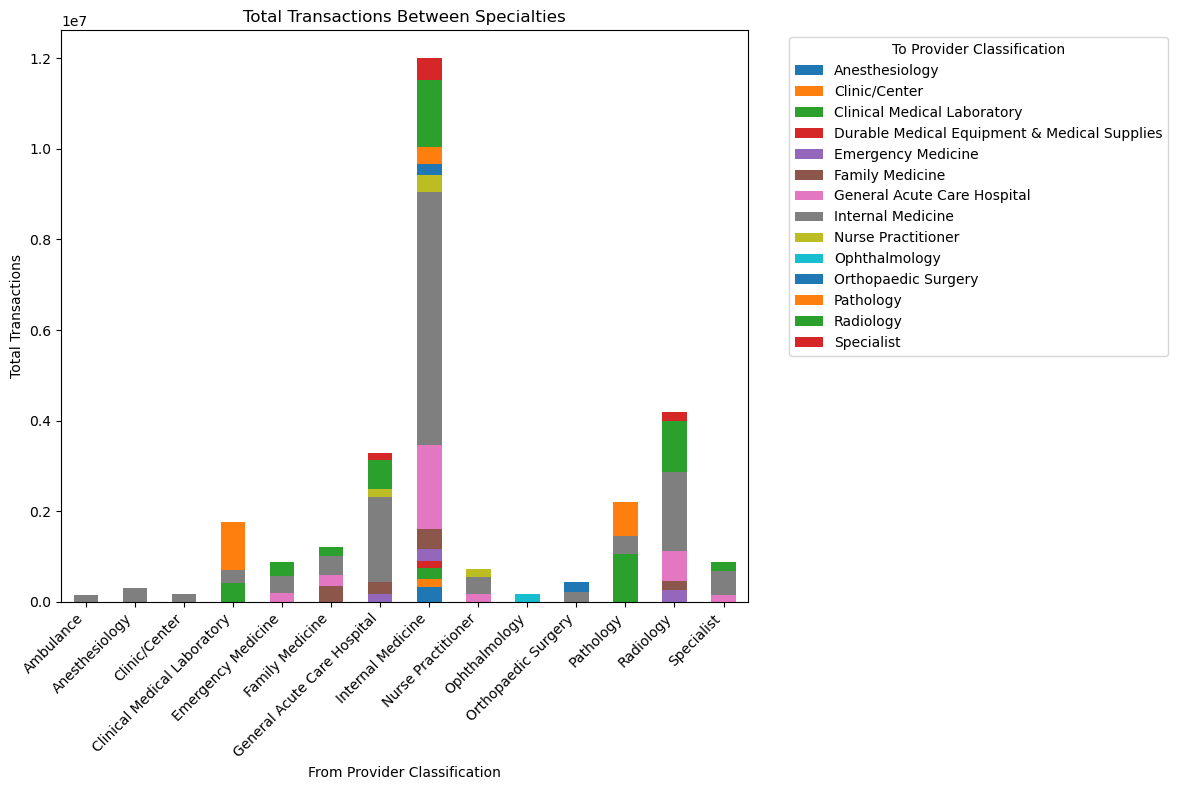

In [53]:
df_sorted = classification_from_to_transactions.sort_values(by='total_transactions', ascending=False).head(50)

# Pivot the dataframe for easy plotting
pivot_df = df_sorted.pivot(index='classification_from_provider', columns='classification_to_provider', values='total_transactions')

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Total Transactions Between Specialties')
plt.xlabel('From Provider Classification')
plt.ylabel('Total Transactions')
plt.legend(title='To Provider Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [54]:
# What is the percentage of the next specialty a type of provider/ hopsital would refer to? 
provider_from_to_transactions = referral_patterns_merge.groupby(["provider_from_name", "provider_to_name"])["transaction_count"].sum().reset_index(name = "total_transactions")

provider_from_to_transactions

,provider_from_name,provider_to_name,total_transactions
0,(RIVERSIDE FAMILY MEDICINE),"ADVANCED DIAGNOSTIC IMAGING, PC",294
1,(RIVERSIDE FAMILY MEDICINE),"ANESTHESIA MEDICAL GROUP, PC",136
2,(RIVERSIDE FAMILY MEDICINE),APRIA HEALTHCARE LLC,53
3,(RIVERSIDE FAMILY MEDICINE),ASSOCIATED PATHOLOGISTS LLC,756
4,(RIVERSIDE FAMILY MEDICINE),"ASSOCIATED PATHOLOGISTS, LLC",784
...,...,...,...
140812,ZERENE STEPHEN,VANDERBILT UNIVERSITY MEDICAL CENTER,234
140813,ZHIJIAN WANG,THOMAS GOLPER,473
140814,ZHIJIAN WANG,VANDERBILT UNIVERSITY MEDICAL CENTER,1282
140815,ZINAH HADIDI,VANDERBILT UNIVERSITY MEDICAL CENTER,65


In [56]:
referral_patterns = nashnpi_from_npi.groupby(["classification", "provider_name"]).size().reset_index(name = "referral_count")


# This code groups the nashnpi_from_npi by classification then by legal business name 
referral_patterns = nashnpi_from_npi.groupby(["classification", "provider_name"]).size().reset_index(name = "referral_count")

# Step 1: Calculate the total number of referrals for each classification
total_referrals = referral_patterns.groupby("classification")["referral_count"].sum().reset_index(name="total_referrals")



In [58]:
# Calculate the total number of referrals for each classification
total_referrals = referral_patterns.groupby("classification")["referral_count"].sum().reset_index(name="total_referrals")

# Merge the total number of referrals back to the referral_patterns dataframe
referral_patterns = referral_patterns.merge(total_referrals, on="classification")

# Calculate the percentage of referrals for each provider within each classification
referral_patterns["referral_percentage"] = (referral_patterns["referral_count"] / referral_patterns["total_referrals"]) * 100
# referral_patterns["referral_percentage"] = referral_patterns["referral_percentage"].round(2).astype(str)+"%"

# Drop unneeded columns
referral_patterns.drop(columns=["total_referrals"], inplace=True)

referral_patterns


,classification,provider_name,referral_count,referral_percentage
0,Advanced Practice Midwife,HEATHER POTTS,1,12.500000
1,Advanced Practice Midwife,MICHELE GIBSON-O'GRADY,4,50.000000
2,Advanced Practice Midwife,REGINA BARUKH,1,12.500000
3,Advanced Practice Midwife,SHANDRA ANDRY,1,12.500000
4,Advanced Practice Midwife,TERRY ZIMMER,1,12.500000
...,...,...,...,...
8998,Urology,WHITSON LOWE,5,0.258398
8999,Urology,WILLIAM BINKLEY,6,0.310078
9000,Urology,"WILLIAM J. BINKLEY, M.D. LLC",5,0.258398
9001,Urology,WILLIAM REYNOLDS,4,0.206718


In [59]:
len(referral_patterns)

9003

In [60]:
len(referral_patterns_merge)

242171

Notes: 
- Merging referral patterns (list of provider from names) to list of npis (from npi_nash df) resulted in less records (total of 156638 rows). 
    - This was because I used pd.merge, which is an inner join. Do a left join instead to keep the same amount of records.
    - Using a left join, I have some missing values in the merge data. 
        - 85,852 rows had NaN provider_to_names. 
- What would it look like merging it with list of npis from the to providers?
- Why are the list of from providers and to providers uneven? Is there more than referral_count of 1? 

In [61]:
referral_patterns_merge_count = referral_patterns_merge.groupby(["provider_from_name", "provider_to_name"]).size().reset_index(name = "referral_count")


referral_patterns_merge_count.head(50)

,provider_from_name,provider_to_name,referral_count
0,(RIVERSIDE FAMILY MEDICINE),"ADVANCED DIAGNOSTIC IMAGING, PC",1
1,(RIVERSIDE FAMILY MEDICINE),"ANESTHESIA MEDICAL GROUP, PC",1
2,(RIVERSIDE FAMILY MEDICINE),APRIA HEALTHCARE LLC,1
3,(RIVERSIDE FAMILY MEDICINE),ASSOCIATED PATHOLOGISTS LLC,1
4,(RIVERSIDE FAMILY MEDICINE),"ASSOCIATED PATHOLOGISTS, LLC",1
5,(RIVERSIDE FAMILY MEDICINE),CENTENNIAL HEART LLC,1
6,(RIVERSIDE FAMILY MEDICINE),CHRISTOPHER CONLEY,1
7,(RIVERSIDE FAMILY MEDICINE),DANIEL WUNDER,1
8,(RIVERSIDE FAMILY MEDICINE),DEREK WELCH,1
9,(RIVERSIDE FAMILY MEDICINE),DOVERSIDE EMERGENCY PHYSICIANS PLLC,1
